# Early cancer detection using signature framework

On essaie ici de différentier les dynamiques malignes des dynamiques bénignes pour les biomarqueurs.

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive-science

'sudo' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [ ]:
!pip install iisignature
!pip install signatory
#!pip install latex

In [ ]:
import signatory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "Computer Modern Roman"
#})
import torch
#import latex


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
local = True
if local:
  import sys
    # Add the directory containing TDA_utils.py to the Python path
  sys.path.append('H://Mon Drive/Etude_Cancer')
else:
  %cd /content/drive/MyDrive/Etude_Cancer


from pga import pga

if local:
  path = 'H://Mon Drive/Etude_Cancer/TDA/Simul/benign_dwi_b'
else:
  path = "./Simul/benign_dwi_b"

On importe les données bénignes:

In [ ]:
data = {}
for b in [0.1,0.12,0.14,0.17]:
  df = pd.read_csv(path+str(b)+".csv",sep = ";")
  df_numpy = df.to_numpy().T[:,:,None]
  data[str(b)]= torch.tensor(pd.read_csv(path+str(b)+".csv",sep = ";").to_numpy().T[:,:,None])

In [ ]:
scale = False
Time = True


data_ben = torch.cat((data['0.1'][1:,1:],data['0.12'][1:,1:],data['0.14'][1:,1:],data['0.17'][1:,1:]))
average = data_ben.mean(axis=1)[:,0]
#data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T
if scale:
  data_ben = data_ben/np.abs(data_ben[:,:,0]).max(dim = 1)[0][:,None,None]

T=1800
time = torch.tensor([300*i for i in range(7)])[None,:,None]/T
times = time.repeat(data_ben.shape[0],1,1)
if Time:
  data_ben= torch.cat((times,data_ben),axis = -1)[:,:]

idx = [i for i in range(10)]
idx = idx+[1000+i for i in range(10)]+[2000+i for i in range(10)]
#plt.plot(data_ben[idx,:,0].T,data_ben[idx,:,1].T)

Pour les passer dans signatory, il faut absolument un torch.tensor. De plus, pour certains propriétés de la signature, on doit inclure un deuxième canal pour obtenir des trajectoires de la forme $(t,X_t)$

On a simulé des données béngines avec différents paramètres, donc on en fait un gros tenseur avec tout le monde

C'est le point crucial:

On a un batch de 5000 trajectoires, avec 7 temps de sampling chacun, et 2 canaux (d'où une shape (5000,7,2)).

On calcule leurs signatures à l'ordre 3. Ce qui va nous donner 15 coeffs par trajectoire.

In [ ]:
depth = 2
shape = signatory.signature_channels(2,depth) # 2 = nombre de canaux
signature_ben = np.empty([1000*(len(data)),shape+1])
print(signature_ben.shape)
#i = 0
#for arrays in data:
#  signature[i:i+1000,:shape] = signatory.signature(data[arrays],depth = 2,basepoint = True)
#  i+=1
signature_ben[:,:shape] = signatory.signature(data_ben,depth = depth)# On rajoute (ou pas) articiellement un point initial t_0=0
signature_ben[:,-1] = 0.5*(signature_ben[:,3]-signature_ben[:,4]) #On crée l'aire de Levy S12-S21
signature_ben.shape

(4000, 7)


(4000, 7)

In [ ]:
words = signatory.all_words(channels = 2, depth = depth)
print(words)

[(0,), (1,), (0, 0), (0, 1), (1, 0), (1, 1)]


In [ ]:

for i in range(signature_ben.shape[-1]):
  plt.hist(signature_ben[:1000,i])
  if i==6:
    plt.title("Levy Area")
  else:
    if len(words[i])>1:
      plt.title(f"Signature coefficient : {(words[i][0]+1,words[i][1]+1)}")
    else:
      plt.title(f"Signature coefficient : {(words[i][0]+1)}")
  plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 640x480 with 1 Axes>

On calcule les quantiles

In [ ]:
print(np.sqrt(np.var(signature_ben[:,1])))
signature_ben[:,1].mean()

9.134452350852786


-0.318

Text(0.5, 1.0, 'Distribution of $S^1(X)$.')

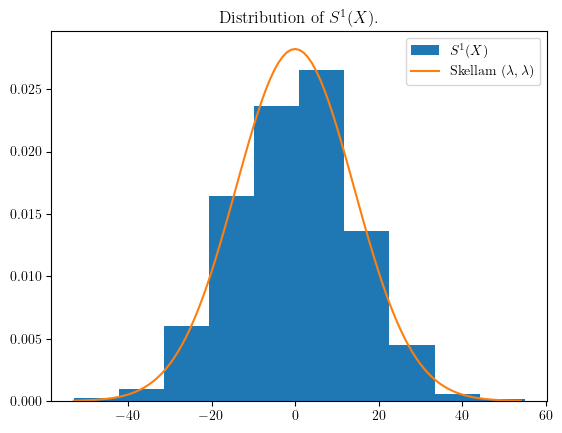

In [ ]:
from scipy.stats import poisson, skellam
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

d = np.log(2)/8
alpha = 100

mu = alpha

x_axis = np.arange(int(signature_ben[:,1].min()),int(signature_ben[:,1].max()))
plt.hist(signature_ben[:,1],density=True,bins=10,label="$S^1(X)$")
#plt.plot(x_axis,poisson.pmf(x_axis,int(mu),loc=-mu),label="Poisson$(B_0d/e)$")
plt.plot(x_axis,skellam.pmf(x_axis,mu1=mu,mu2=mu,loc = 0),label="Skellam $(\lambda,\lambda)$")
plt.legend()
plt.title("Distribution of $S^1(X)$.")

Text(0.5, 1.0, 'Distribution of $S^{12}(X)$.')

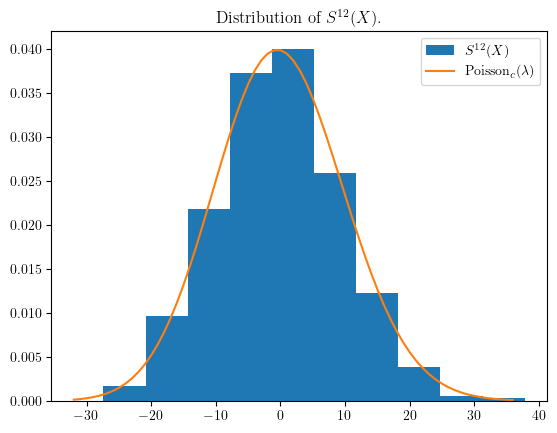

In [ ]:
from scipy.stats import poisson
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

d = np.log(2)/8
alpha = 100

mu = alpha
mu1 = alpha
mu2 = alpha

i = 3

x_axis = np.arange(int(signature_ben[:,i].min()),int(signature_ben[:,i].max()))
plt.hist(signature_ben[:1000,i],density=True,bins=10,label="$S^{12}(X)$")
plt.plot(x_axis,poisson.pmf(x_axis,int(mu),loc=-int(mu)),label="Poisson$_c(\lambda)$")
#plt.plot(x_axis,skellam.pmf(x_axis,mu1=mu1,mu2=mu2,loc = -mu1+mu2),label="Skellam $(1,1)$")
plt.legend()
plt.title("Distribution of $S^{12}(X)$.")

Text(0.5, 1.0, 'Distribution of $LA(X)$.')

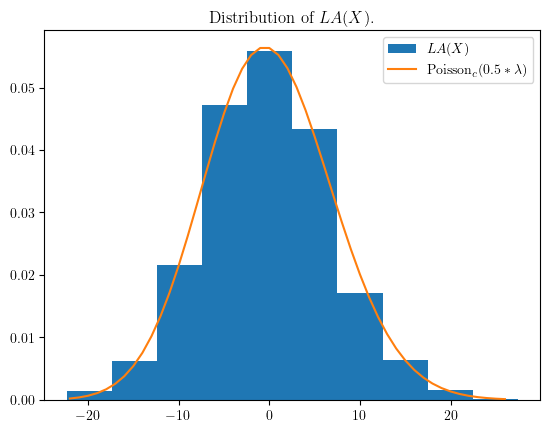

In [ ]:
from scipy.stats import poisson
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

d = np.log(2)/8
alpha = 100

mu = alpha*0.5

i = -1

x_axis = np.arange(int(signature_ben[:,i].min()),int(signature_ben[:,i].max()))
plt.hist(signature_ben[:,i],density=True,bins=10,label="$LA(X)$")
plt.plot(x_axis,poisson.pmf(x_axis,int(mu),loc=-int(mu)),label="Poisson$_c(0.5*\lambda)$")
#plt.plot(x_axis,skellam.pmf(x_axis,mu1=mu,mu2=mu,loc = 0),label="Skellam $(1,1)$")
plt.legend()
plt.title("Distribution of $LA(X)$.")

0.1333611049329241


Text(0.5, 1.0, 'Distribution of $S^{21}(X)$.')

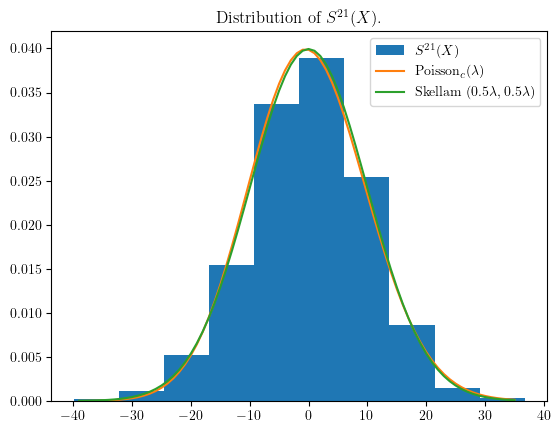

In [ ]:
from scipy.stats import skellam
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

d = np.log(2)/8
alpha = 100
delta = 0.5
mu1= alpha*delta

i = 4

print(signature_ben[:,i].mean())
x_axis1 = np.arange(-10,10)
x_axis = np.arange(int(signature_ben[:,i].min()),int(signature_ben[:,i].max()))
plt.hist(signature_ben[:,i],density=True,bins=10,label="$S^{21}(X)$")
plt.plot(x_axis,poisson.pmf(x_axis,mu,loc=-mu),label="Poisson$_c(\lambda)$")
plt.plot(x_axis,skellam.pmf(x_axis,mu1=mu1,mu2=mu1,loc = 0),label="Skellam $(0.5\lambda,0.5\lambda)$")
plt.legend()
plt.title("Distribution of $S^{21}(X)$.")

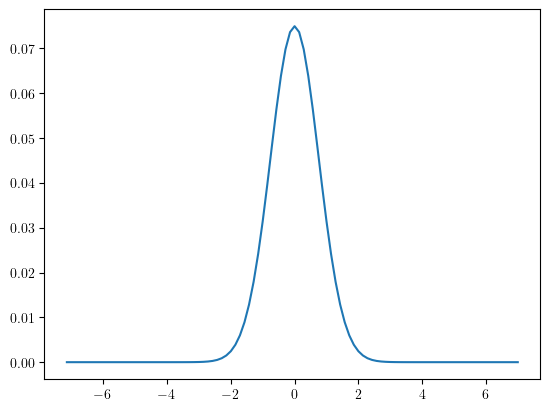

In [ ]:
x_axis1 = np.arange(-50,50)
plt.plot(x_axis1/7,skellam.pmf(x_axis1,mu1=mu1,mu2=mu1,loc = 0),label="Poisson $(TB_0d/e)$")


Text(0.5, 1.0, 'Distribution of S1(X)')

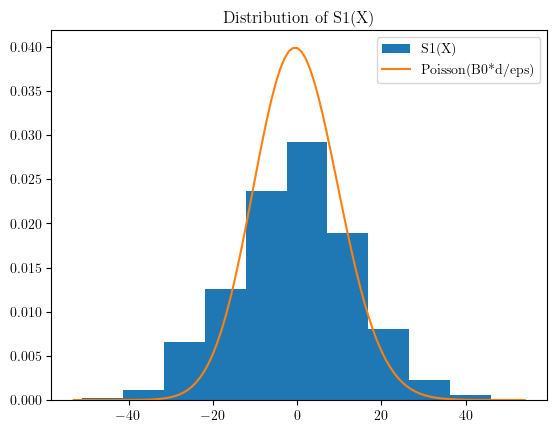

In [ ]:
from scipy.stats import poisson

d = np.log(2)/8
alpha = 100

mu = alpha

x_axis = np.arange(int(signature_ben[:,1].min()),int(signature_ben[:,1].max()))
plt.hist(signature_ben[:1000,1],density=True,bins=10,label="S1(X)")
plt.plot(x_axis,poisson.pmf(x_axis,int(mu),loc=-int(mu)),label="Poisson(B0*d/eps)")
plt.legend()
plt.title("Distribution of S1(X)")

In [ ]:
poisson.pmf(x_axis,mu,loc=-mu)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

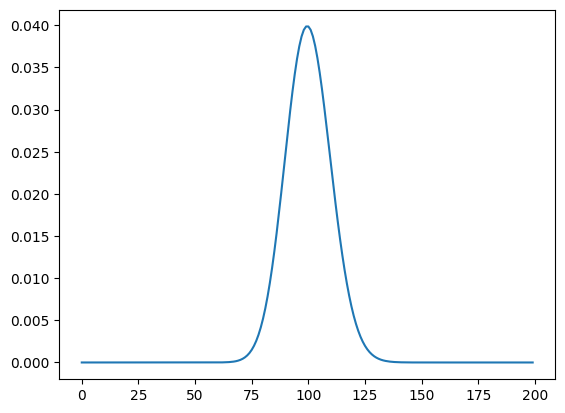

In [ ]:
x_axis1 = np.arange(0,200)
plt.plot(x_axis1,poisson.pmf(x_axis1,100,loc=0))

In [ ]:
quant_ben = np.quantile(np.abs(signature_ben), q= 0.95, axis = 0)
print(quant_ben)

[2.1000000e+03 1.7750000e+01 2.2050000e+06 3.9918750e+04 3.3187500e+03
 1.5753125e+02 2.1301875e+04]


In [ ]:
import os
import re

if local:
  directory = 'H://Mon Drive/Etude_Cancer/TDA/Simul/'
else:
  directory = "./Simul/"

def starts_with_benign(s):
    return s.startswith("benign")
def starts_with_desktop(s):
    return s.startswith("desktop")

classif = []
data_ben_mal = {}
#directory = './Simul'
for filename in os.listdir(directory):
    if starts_with_benign(filename):
      i = 1
    else:
      if starts_with_desktop(filename):
        i = 1
      else:
        f = os.path.join(directory, filename)
        data_ben_mal[filename]= torch.tensor(pd.read_csv(f,sep = ";").to_numpy().T[:,:,None])


In [ ]:
for array in data_ben_mal:
  print(array)
  print(data_ben_mal[array].shape)

mal_0.07_r0.004.csv
torch.Size([1001, 7, 1])
mal_0.07_r0.001.csv
torch.Size([1001, 7, 1])
mal_0.07_r0.002.csv
torch.Size([1001, 7, 1])
mal_0.1_r0.001.csv
torch.Size([1001, 7, 1])
mal_0.07_r0.007.csv
torch.Size([1001, 7, 1])
mal_0.07_r0.01.csv
torch.Size([1001, 7, 1])
mal_0.1_r0.01.csv
torch.Size([1001, 7, 1])
mal_0.07_r0.015.csv
torch.Size([1001, 7, 1])
mal_0.1_r0.004.csv
torch.Size([1001, 7, 1])
mal_0.1_r0.007.csv
torch.Size([1001, 7, 1])
mal_0.1_r0.002.csv
torch.Size([1001, 7, 1])
mal_0.15_r0.002.csv
torch.Size([1001, 7, 1])
mal_0.15_r0.001.csv
torch.Size([1001, 7, 1])
mal_0.1_r0.015.csv
torch.Size([1001, 7, 1])
mal_0.25_r0.015.csv
torch.Size([1001, 7, 1])
ben_mal_0.25_r0.015.csv
torch.Size([1001, 7, 1])
ben_mal_0.15_r0.007.csv
torch.Size([1001, 7, 1])
ben_mal_0.2_r0.007.csv
torch.Size([1001, 7, 1])
ben_mal_0.2_r0.01.csv
torch.Size([1001, 7, 1])
ben_mal_0.25_r0.002.csv
torch.Size([1001, 7, 1])
mal_0.15_r0.015.csv
torch.Size([1001, 7, 1])
mal_0.15_r0.004.csv
torch.Size([1001, 7, 1])
b

In [ ]:
data_mal = torch.cat(tuple([data_ben_mal[filename][1:] for filename in data_ben_mal.keys()]))
average = data_mal.mean(axis=1)[:,0]
#data_mal = (data_mal.T-data_mal.mean(axis=1)[:,0]).T
if scale:
  data_mal = data_mal/np.abs(data_mal[:,:,0]).max(dim = 1)[0][:,None,None]

T=1800
time = torch.tensor([300*i for i in range(7)])[None,:,None]/T
times = time.repeat(data_mal.shape[0],1,1)
if Time:
  data_mal= torch.cat((times,data_mal),axis = -1)[:,:]

idx = [i for i in range(10)]
idx = idx+[1000+i for i in range(10)]+[2000+i for i in range(10)]
#plt.plot(data_mal[idx,:,0].T,data_mal[idx,:,1].T)
print(data_mal.shape)

torch.Size([66000, 7, 2])


In [ ]:
depth = 2
shape = signatory.signature_channels(2,depth)
signature_mal = np.empty([1000*len(data_ben_mal),shape+1])
print(signature_mal.shape)
#i = 0
#for arrays in data:
#  signature[i:i+1000,:shape] = signatory.signature(data[arrays],depth = 2,basepoint = True)
#  i+=1
signature_mal[:,:shape] = signatory.signature(data_mal,depth = depth)#,basepoint = True)
signature_mal[:,-1] = 0.5*(signature_mal[:,3]-signature_mal[:,4])

(66000, 7)


## Test:
Dans la cellule suivante, on teste chaque coefficient:
Si coeff>quantile => 1, sinon 0.


In [ ]:
quant_ben = np.quantile(np.abs(signature_ben), q= 0.95, axis = 0)


In [ ]:
res_pos = []
for i in range(signature_mal.shape[-1]):
  res_pos.append(sum(np.abs(signature_mal[:,i])>quant_ben[i])/signature_mal.shape[0])
  print(sum(np.abs(signature_mal[:,i])>quant_ben[i])/signature_mal.shape[0])

0.0
0.9999848484848485
0.0
1.0
0.9839696969696969
0.9999848484848485
0.9998636363636364


In [ ]:
TP = []
FN = []
for i in range(signature_mal.shape[-1]):
  TP.append(sum(np.abs(signature_mal[:,i])>quant_ben[i]))
  FN.append(signature_mal.shape[0]-sum(np.abs(signature_mal[:,i])>quant_ben[i]))

print("TP:"+str(TP))
print("Fn:"+str(FN))

TP = np.array(TP)
FN = np.array(FN)

TP:[0, 65999, 0, 66000, 64942, 65999, 65998]
Fn:[66000, 1, 66000, 0, 1058, 1, 2]


In [ ]:
TN = []
FP = []
for i in range(signature_mal.shape[-1]):
  FP.append(sum(np.abs(signature_ben[:,i])>quant_ben[i]))
  TN.append(signature_ben.shape[0]-sum(np.abs(signature_ben[:,i])>quant_ben[i]))

print("TN:"+str(TN))
print("FP:"+str(FP))

TN = np.array(TN)
FP = np.array(FP)

TN:[3000, 2852, 3000, 2850, 2850, 2852, 2850]
FP:[0, 148, 0, 150, 150, 148, 150]


In [ ]:
TN

array([250,   0, 250, 250, 250,   0, 250, 250, 250, 250, 250, 249, 250,
         0, 250])

In [ ]:
test_mult_no_corr = []
for i in range(signature_mal.shape[0]):
  test_mult_no_corr.append(sum(np.abs(signature_mal[i])>quant_ben)>0)
sum(test_mult_no_corr)/signature_mal.shape[0]



1.0

In [ ]:
# Calcul de l'accuracy
accuracy = (TP + TN) / (TP + TN + FP + TN)

# Calcul de la précision
precision = TP / (TP + FP)

# Calcul du recall
recall = TP / (TP + FN)

# Calcul du F1 Score
f1_score = 2 * precision * recall / (precision + recall)

print(f'Accuracy: {accuracy.T}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-SCORE: {f1_score}')

df = pd.DataFrame(data = {'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-Score':f1_score})

print(df)


Accuracy: [0.5        0.95824693 0.5        0.95824635 0.95762233 0.95824693
 0.95824518]
Precision: [       nan 0.99776256        nan 0.99773243 0.99769557 0.99776256
 0.99773236]
Recall: [0.         0.99998485 0.         1.         0.9839697  0.99998485
 0.9999697 ]
F1-SCORE: [       nan 0.99887247        nan 0.99886493 0.9907851  0.99887247
 0.99884977]
   Accuracy  Precision    Recall  F1-Score
0  0.500000        NaN  0.000000       NaN
1  0.958247   0.997763  0.999985  0.998872
2  0.500000        NaN  0.000000       NaN
3  0.958246   0.997732  1.000000  0.998865
4  0.957622   0.997696  0.983970  0.990785
5  0.958247   0.997763  0.999985  0.998872
6  0.958245   0.997732  0.999970  0.998850


<ipython-input-328-a3e6fb7ce390>:5: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


In [ ]:
TP_mult = sum(test_mult_no_corr)
FN_mult = signature_mal.shape[0]-sum(test_mult_no_corr)

print("TP:"+str(TP_mult))
print("FN:"+str(FN_mult))

test_mult_no_corr_ben = []
for i in range(signature_ben.shape[0]):
  test_mult_no_corr_ben.append(sum(np.abs(signature_ben[i])>quant_ben)>0)

TN_mult = signature_ben.shape[0]-sum(test_mult_no_corr_ben)
FP_mult = sum(test_mult_no_corr_ben)
print("TN:"+str(TN_mult))
print("FP:"+str(FP_mult))


TP:65974
FN:26
TN:4263
FP:737


In [ ]:
# Calcul de l'accuracy
accuracy_multi = (TP_mult + TN_mult) / (TP_mult + TN_mult + FP_mult + TN_mult)

# Calcul de la précision
precision_multi = TP_mult / (TP_mult + FP_mult)

# Calcul du recall
recall_multi = TP_mult / (TP_mult + FN_mult)

# Calcul du F1 Score
f1_score_multi = 2 * precision_multi * recall_multi / (precision_multi + recall_multi)


print(f'Accuracy: {accuracy_multi}')
print(f'Precision: {precision_multi}')
print(f'Recall: {recall_multi}')
print(f'F1-SCORE: {f1_score_multi}')

Accuracy: 0.9335433363903398
Precision: 0.9889523466894515
Recall: 0.9996060606060606
F1-SCORE: 0.9942506649787884


# Tests d'hypothèses.

Sous $H_0:$ la tumeur est bénigne, on teste les hypothèses suivantes:

## $S^2(X):$

On construit la statistique de test $S^1(X)$. Sous $H_0$, on a:
$S^2(X)\sim \text{Skellam }(\mathbb{E}_{t}[X],\mathbb{E}_{t}[X])$


In [ ]:
def test_S2(X):
  M = X[:,:,-1].mean(axis = -1)
  sig = signatory.Signature(depth  = 2)
  signatures = sig(X)
  s = signatures[:,1]
  return skellam.sf(s, M, M, loc=0)

In [ ]:
print(sum(test_S2(data_ben)>0.05)/data_ben.shape[0])
print(sum(test_S2(data_mal)<0.05)/data_mal.shape[0])

0.946
0.9999393939393939


In [ ]:
def test_S12(X):
  M = X[:,:,-1].mean(axis=-1)
  sig = signatory.Signature(depth  = 2)
  signatures = sig(X)
  s = signatures[:,3]
  return poisson.sf(s, M, loc=-M)

In [ ]:
print(sum(test_S12(data_ben)>0.05)/data_ben.shape[0])
print(sum(test_S12(data_mal)<0.05)/data_mal.shape[0])

0.9546666666666667
1.0


In [ ]:
def test_S21(X):
  M = X[:,:,-1].mean(axis=-1)
  sig = signatory.Signature(depth  = 2)
  signatures = sig(X)
  s = signatures[:,4]
  return poisson.sf(s, M, loc=-M)

print(sum(test_S21(data_ben)>0.05)/data_ben.shape[0])
print(sum(test_S21(data_mal)<0.05)/data_mal.shape[0])

0.952
0.9691666666666666


In [ ]:
def test_LA(X):
  M = X[:,:,-1].mean(axis=-1)/2
  sig = signatory.Signature(depth  = 2)
  signatures = sig(X)
  s = 0.5*(signatures[:,3]-signatures[:,4])
  return poisson.sf(s, M, loc=-M)

print(sum(test_LA(data_ben)>0.05)/data_ben.shape[0])
print(sum(test_LA(data_mal)<0.05)/data_mal.shape[0])

0.9526666666666667
0.9997272727272727


In [ ]:
from scipy.stats import false_discovery_control

def test_corr(X):
  p1 =  test_S2(X)
  p2 =  test_S12(X)
  p3 =  test_S21(X)
  p4 =  test_LA(X)
  p = np.array([p1,p2,p3,p4])
  return false_discovery_control(p, axis = 0, method='bh')

print(sum(test_corr(data_ben)[0]>0.05)/data_ben.shape[0])
print(sum(test_corr(data_mal)[0]<0.05)/data_mal.shape[0])

0.9833333333333333
0.9999393939393939


In [ ]:
TP_test = sum(test_corr(data_mal)[0]<0.05)
FN_test = signature_mal.shape[0]-TP_test

print("TP:"+str(TP_test))
print("FN:"+str(FN_test))


TN_test = sum(test_corr(data_ben)[0]>0.05)
FP_test = data_ben.shape[0]-TN_test
print("TN:"+str(TN_test))
print("FP:"+str(FP_test))

TP:65996
FN:4
TN:2950
FP:50


In [ ]:
# Calcul de l'accuracy
accuracy = (TP_test + TN_test) / (TP_test + TN_test + FP_test + TN_test)

# Calcul de la précision
precision = TP_test / (TP_test + FP_test)

# Calcul du recall
recall = TP_test / (TP_test + FN_test)

# Calcul du F1 Score
f1_score = 2 * precision * recall / (precision + recall)

print(f'Accuracy: {accuracy.T}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-SCORE: {f1_score}')

#df = pd.DataFrame(data = {'Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1-Score':f1_score})

#print(df)

Accuracy: 0.958302059878242
Precision: 0.9992429518820216
Recall: 0.9999393939393939
F1-SCORE: 0.9995910516032291
